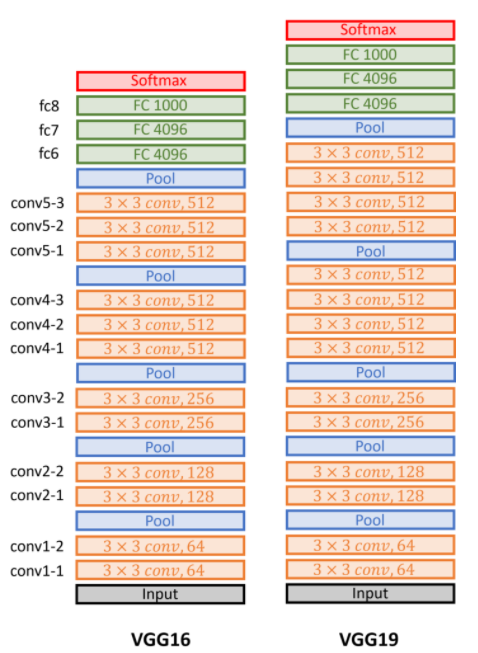
VGG Architecture  
Basic Image size => 3 224 224  

In [1]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [3]:
import torch.nn as nn
import torch

In [39]:
class VGG_make(nn.Module):
    def __init__(self):
        super(VGG_make,self).__init__()
        
        self.conv=nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.BN=nn.BatchNorm2d(64)
        self.act=nn.ReLU(inplace=True)
        
        self.conv1=nn.Conv2d(64,64,kernel_size=3,padding=1)
    
        self.conv2=nn.Conv2d(64, 128,kernel_size=3,padding=1)
        self.BN1=nn.BatchNorm2d(128)
        self.act=nn.ReLU(inplace=True)
        
        self.conv3=nn.Conv2d(128, 128,kernel_size=3,padding=1)
        self.conv4=nn.Conv2d(128, 256,kernel_size=3,padding=1)
        self.conv5=nn.Conv2d(256, 256,kernel_size=3,padding=1)
        
        self.BN2=nn.BatchNorm2d(256)
        
        self.conv6=nn.Conv2d(256, 512,kernel_size=3,padding=1)
        self.conv7=nn.Conv2d(512, 512,kernel_size=3,padding=1)
        self.conv8=nn.Conv2d(512, 512,kernel_size=3,padding=1)
        
        self.BN3=nn.BatchNorm2d(512)
        self.max=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.fc=nn.Linear(512,256)
        self.fc1=nn.Linear(256,256)
        self.fc2=nn.Linear(256,10)
    def forward(self,x):
        x=self.act(self.BN(self.conv(x)))
        x=self.act(self.BN(self.conv1(x)))
        x=self.max(x)
        x=self.act(self.BN1(self.conv2(x)))
        x=self.act(self.BN1(self.conv3(x)))
        x=self.max(x)
        x=self.act(self.BN2(self.conv4(x)))
        x=self.act(self.BN2(self.conv5(x)))
        x=self.max(x)
        x=self.act(self.BN3(self.conv6(x)))
        x=self.act(self.BN3(self.conv7(x)))
        x=self.act(self.BN3(self.conv8(x)))
        x=self.max(x)
        x=self.act(self.BN3(self.conv8(x)))
        x=self.act(self.BN3(self.conv8(x)))
        x=self.act(self.BN3(self.conv8(x)))
        x=self.max(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        x=self.fc1(x)
        x=self.fc2(x)
        return x

In [40]:
def dimension_check():
    net = VGG_make()
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [41]:
dimension_check()

torch.Size([2, 10])


In [42]:
def train(net,partition,optimizer,criterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=128,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        #break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [43]:
def test(net, partition):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=128, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [44]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=128, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [50]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [47]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

In [51]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
net=VGG_make()
net.cuda()
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in range(5):
    ts=time.time()
    net, train_loss,train_acc=train(net, partition, optimizer, criterion)
    val_loss, val_acc = validate(net, partition, criterion)
    te=time.time()
    print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))
    train_loss=round(train_loss,2)
    val_loss=round(val_loss,2)
    train_acc=round(train_acc,2)
    val_acc=round(val_acc,2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
test_acc = test(net,partition)
test_acc=round(test_acc,2)

  0%|          | 1/313 [00:00<00:40,  7.71it/s]

time : 45.02, train_loss : 1.92, train_acc : 23.92,val_acc : 14.51,val_loss : 2.62


  0%|          | 1/313 [00:00<00:40,  7.68it/s]

time : 45.73, train_loss : 1.44, train_acc : 44.30,val_acc : 13.08,val_loss : 2.25


  0%|          | 1/313 [00:00<00:42,  7.39it/s]

time : 46.22, train_loss : 1.10, train_acc : 60.15,val_acc : 9.97,val_loss : 2.81


  0%|          | 1/313 [00:00<00:41,  7.57it/s]

time : 46.40, train_loss : 0.85, train_acc : 70.00,val_acc : 9.97,val_loss : 3.12


  0%|          | 0/79 [00:00<?, ?it/s]

time : 46.53, train_loss : 0.69, train_acc : 76.47,val_acc : 10.23,val_loss : 3.13


100%|██████████| 79/79 [00:07<00:00, 10.83it/s]


In [ ]:
# VGG=> Simple Code
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self,vgg_name,num_classes=1000):
        super(VGG,self).__init__()
        self.features= self._make_layers(cfg[vgg_name]) # 함수 앞 _는 private
        self.classifier = nn.Linear(25088, num_classes)
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    def _make_layers(self,cfg):
        layers=[]
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2,stride=2)]
            else :
                layers +=[nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                          nn.BatchNorm2d(x),
                          nn.ReLU(inplace=True)]
                in_channels =x
        layers+=[nn.AvgPool2d(kernel_size=1,stride=1)]
        return nn.Sequential(*layers)
        